# CAPSTONE PROJECT - NLP Chatbot Interface

## PROBLEM STATEMENT

• DOMAIN: Industrial safety. NLP based Chatbot.

• CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the
globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.




• DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an
occurrence of an accident.

• Columns description: <br>
 - Data: timestamp or time/date information<br>
 - Countries: which country the accident occurred (anonymised)<br>
 - Local: the city where the manufacturing plant is located (anonymised)<br>
 - Industry sector: which sector the plant belongs to<br>
 - Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)<br>
 - Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)<br>
 - Genre: if the person is male of female<br>
 - Employee or Third Party: if the injured person is an employee or a third party<br>
 - Critical Risk: some description of the risk involved in the accident<br>
 - Description: Detailed description of how the accident happened.<br>

## • PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident
description.

## **Installing and Importing Necessary Libraries**

In [57]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

# Install the required libraries
%pip install -U sentence-transformers gensim transformers tqdm -q

# Upgrade the click package to resolve the dependency conflict
%pip install click --upgrade

# Check the version of scikit-learn
import sklearn
print(sklearn.__version__)

# Reinstall scikit-learn if necessary
%pip install --upgrade scikit-learn

# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To suppress warnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

1.6.1


## **Import the data**

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Load dataset.
industry = pd.read_excel("/content/drive/MyDrive/data_files/DataSet_Industrial_safety_and_health_db_with_accidents_description.xlsx")
industry_df = industry.copy()

## **Data Overview and Data cleansing**

In [60]:
industry_df.shape

(425, 11)

**Observations:**
* In `industry_df` there are 425 records and 11 columns.

In [61]:
industry_df.columns.tolist()

['Unnamed: 0',
 'Date',
 'Countries',
 'Local',
 'Industry Sector',
 'Accident Level',
 'Potential Accident Level',
 'Gender',
 'Employee or Third Party',
 'Critical Risk',
 'Description']

In [62]:
industry_df.head()

,Unnamed: 0,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


### Drop irrelevant column Unnamed:0

In [63]:
# Drop irrelevant column Unnamed:0
industry_df.drop('Unnamed: 0', axis=1, inplace=True)

In [64]:
industry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      425 non-null    datetime64[ns]
 1   Countries                 425 non-null    object        
 2   Local                     425 non-null    object        
 3   Industry Sector           425 non-null    object        
 4   Accident Level            425 non-null    object        
 5   Potential Accident Level  425 non-null    object        
 6   Gender                    425 non-null    object        
 7   Employee or Third Party   425 non-null    object        
 8   Critical Risk             425 non-null    object        
 9   Description               425 non-null    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 33.3+ KB


**Observations:**
* There are 9 object and 1 datatime datatypes.

### Check Null values in data set.

In [65]:
industry_df.isnull().sum()

,0
Date,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Gender,0
Employee or Third Party,0
Critical Risk,0
Description,0


**Observations:**
* There are no nulls values.

In [66]:
industry_df.nunique()

,0
Date,287
Countries,3
Local,12
Industry Sector,3
Accident Level,5
Potential Accident Level,6
Gender,2
Employee or Third Party,3
Critical Risk,33
Description,411


### Check for duplicates

In [67]:
industry_df.duplicated().sum()

7

**Observations:**
* There are 7 duplicate values found in the dataset.

In [68]:
# Drop the duplicate values from the dataframe using drop_duplicates function.
industry_df.drop_duplicates(inplace=True)
print('Shape of the dataset after removing duplicates is :',industry_df.shape)

Shape of the dataset after removing duplicates is : (418, 10)


### Lets check duplicates on column level and drop as its required for further analysis.

In [69]:
industry_df.duplicated(subset=['Description'],keep=False).sum()

14

In [70]:
industry_df[industry_df.duplicated(subset=['Description'],keep=False)].sort_values(by='Description')

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description
166,2016-07-07,Country_01,Local_03,Mining,IV,V,Male,Third Party,Others,At moments when the MAPERU truck of plate F1T ...
167,2016-07-07,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,At moments when the MAPERU truck of plate F1T ...
261,2016-12-01,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
263,2016-12-01,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,During the activity of chuteo of ore in hopper...
412,2017-06-20,Country_01,Local_01,Mining,I,IV,Male,Employee,Others,"In circumstance, the AHK-903 license plate (Em..."
413,2017-06-20,Country_01,Local_01,Mining,I,IV,Male,Third Party,Others,"In circumstance, the AHK-903 license plate (Em..."
130,2016-05-26,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,"In the geological reconnaissance activity, in ..."
131,2016-05-26,Country_03,Local_10,Others,I,I,Male,Employee,Others,"In the geological reconnaissance activity, in ..."
143,2016-06-08,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,Project of Vazante that carried out sediment c...
144,2016-06-08,Country_03,Local_10,Others,I,I,Male,Third Party,Others,Project of Vazante that carried out sediment c...


**Observations:**
* There are 7 duplicate values found in the dataset based on the descrition column.
* As per observation the incidents which are having duplicate values happened on the same time stamp (Date Column).
* Hence we can drop these hidden duplicates.

In [71]:
industry_df.drop_duplicates(subset=['Description'], keep='first', inplace=True)

In [72]:
print('Shape of the dataset after removing duplicates based on description column is :',industry_df.shape)

Shape of the dataset after removing duplicates based on description column is : (411, 10)


### Lets check the count of unique values in each columns except Description and Date as they are text-heavy or non-numeric

In [73]:
# Looping through all the columns in the dataframe and checking counts of unique values.
for col in industry_df.columns:
    if (col!='Description') and (col!='Date'):
        print(industry_df[col].value_counts())
        print('_'*50)

Countries
Country_01    245
Country_02    127
Country_03     39
Name: count, dtype: int64
__________________________________________________
Local
Local_03    87
Local_05    59
Local_01    55
Local_04    55
Local_06    46
Local_10    39
Local_08    27
Local_02    23
Local_07    12
Local_12     4
Local_09     2
Local_11     2
Name: count, dtype: int64
__________________________________________________
Industry Sector
Mining    232
Metals    134
Others     45
Name: count, dtype: int64
__________________________________________________
Accident Level
I      303
II      39
III     31
IV      30
V        8
Name: count, dtype: int64
__________________________________________________
Potential Accident Level
IV     138
III    106
II      95
I       43
V       28
VI       1
Name: count, dtype: int64
__________________________________________________
Gender
Male      390
Female     21
Name: count, dtype: int64
__________________________________________________
Employee or Third Party
Third Part

**Observations**

1. **Countries**: Most incidents in Country_01 (245), fewer in Country_02 (127) and Country_03 (39).  
2. **Local**: Local_03 (87) had the most cases, Local_11 and Local_09 the least (2 each).  
3. **Industry Sector**: Mining (232) led incidents, followed by Metals (134) and Others (45).  
4. **Accident Level**: Most accidents were Level I (303), with progressively fewer cases for higher levels, and only 8 cases at Level V.
5. **Potential Accident Level**: Level IV (138) was most common, Level VI rare (1 case).  
6. **Genre**: Incidents mostly involved males (390), few females (21).  
7. **Employee or Third Party**: Employees (176) and third parties (180) dominated, remote cases fewer (55).  
8. **Critical Risk**: "Others" (223) was most common; many risks had single occurrences.

## **Exploratory Data Analysis (EDA)**

### Univariate Analysis

In [74]:
# Creating a function to make univariate plots for analysis
def plot(df,col, title, palette, edgecolor):

    value = df[col].value_counts()[1]
    plt.figure(figsize = (20,15))
    plt.subplot(2,2,1)
    sns.countplot(df[col], palette = palette, edgecolor = edgecolor, order=df[col].value_counts().index, alpha = 1.0, saturation=1);
    plt.title(title);

    plt.subplot(2,2,2)
    # colors = ['yellowgreen', 'violet', 'orange', 'grey', 'cyan']
    colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']  # Custom color list


    plt.pie(df[col].value_counts(), autopct = "%.2f",
       labels = df[col].value_counts().index , shadow = True, explode = [0.1]*len(df[col].value_counts().index), startangle = -135, colors=colors);
    plt.title(title);
    plt.show()

### Lets analyze the features in data set

## Countries

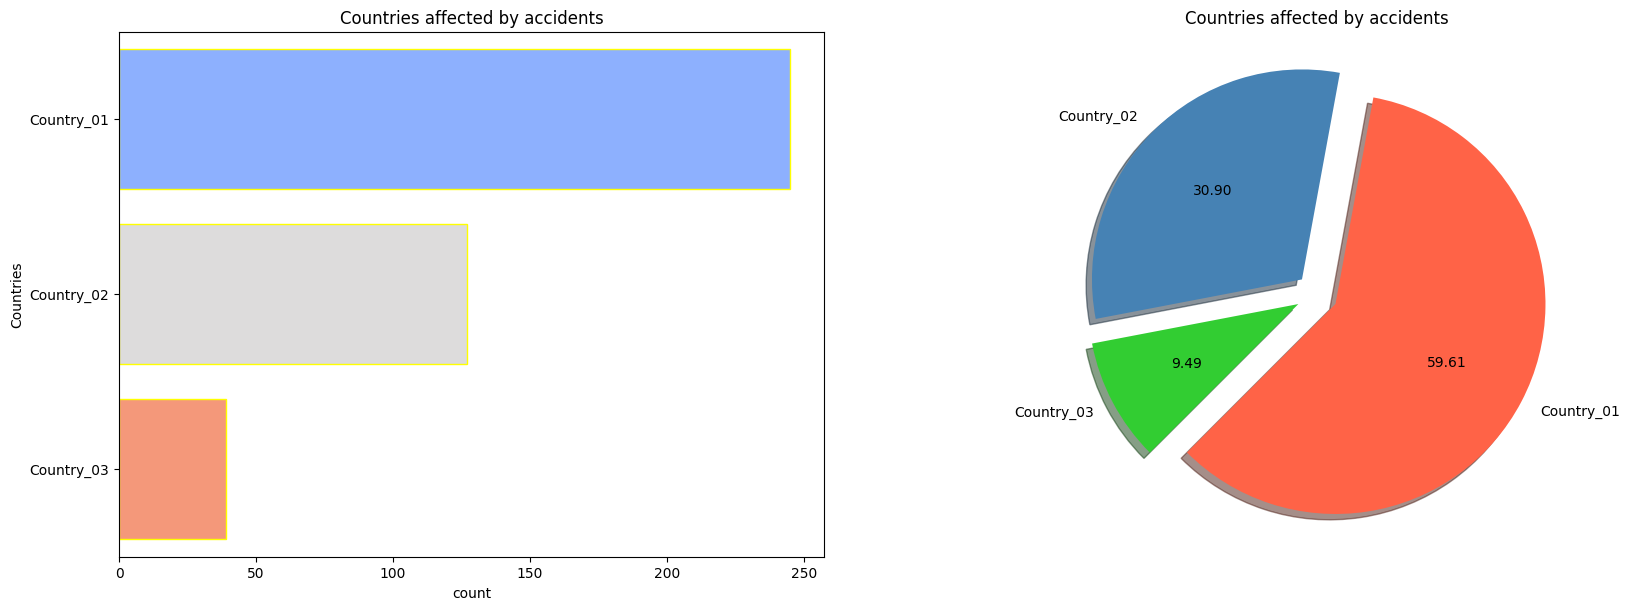

In [75]:
plot(industry_df,'Countries', 'Countries affected by accidents', 'coolwarm', 'yellow')

**Observations**

1. **Country_01 (245 cases, 59%)** – Highest accident count, possibly due to hazardous industries or weaker safety measures.  
2. **Country_02 (127 cases, 30%)** – Significant accident cases, requiring further investigation into industry sectors and risks.  
3. **Country_03 (39 cases, 9%)** – Lowest accidents, possibly due to better safety compliance or lower-risk operations.  

## Industry Sector

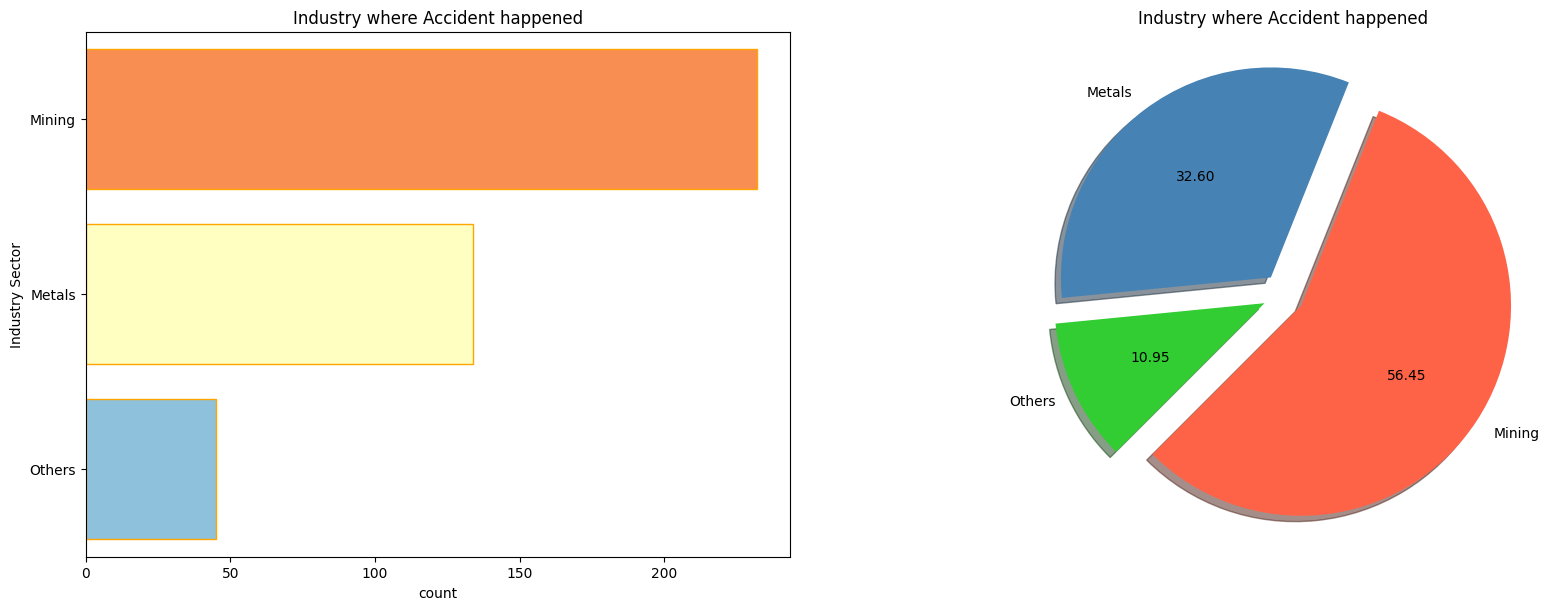

In [76]:
plot(industry_df,'Industry Sector', 'Industry where Accident happened', 'RdYlBu', 'orange')

**Observations**

1. **Mining (232 cases, 57%)** – Highest accident-prone sector, likely due to hazardous working conditions.  
2. **Metals (134 cases, 33%)** – Significant accident cases, possibly from heavy machinery and manual handling risks.  
3. **Others (45 cases, 10%)** – Least accidents, indicating lower-risk industries or better safety protocols.  

## Gender

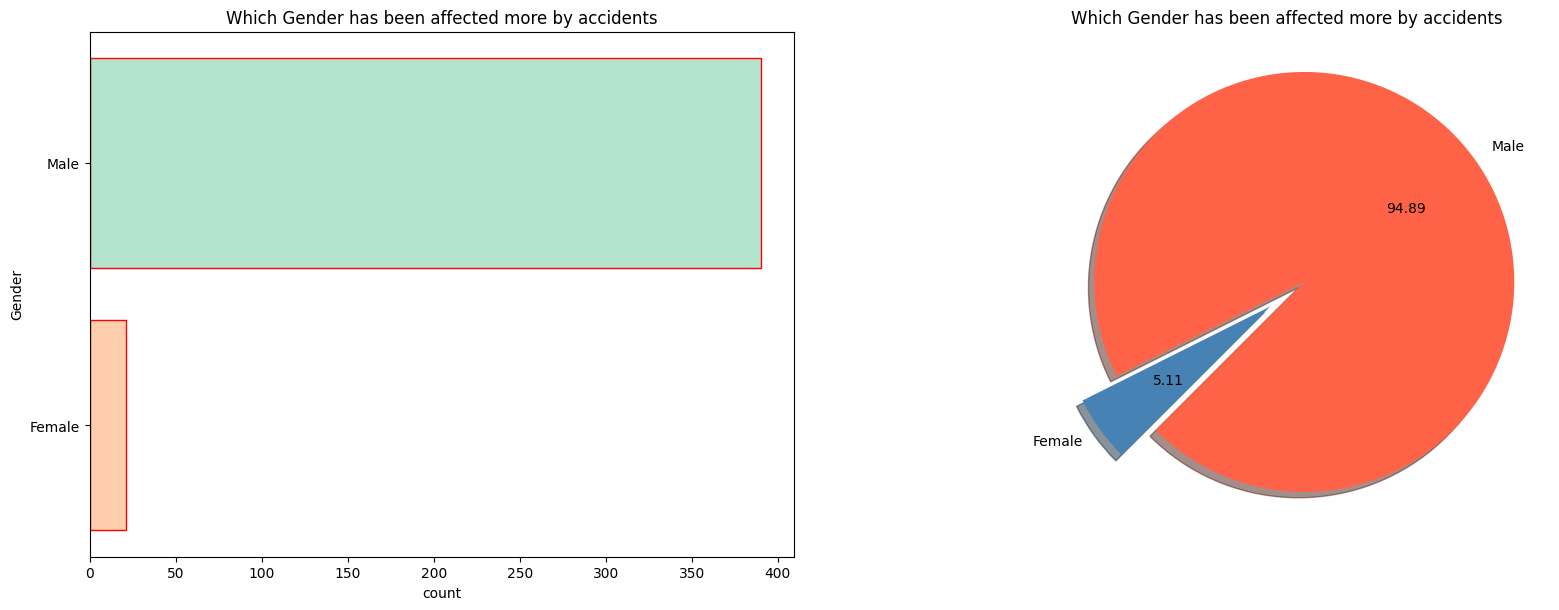

In [77]:
plot(industry_df,'Gender', 'Which Gender has been affected more by accidents', 'Pastel2', 'red')

**Observations**
1. **Male (390 cases, 95%)** – Majority of accidents involve male workers, likely due to higher workforce participation in hazardous roles.  
2. **Female (21 cases, 5%)** – Significantly fewer accidents, possibly due to lower representation in high-risk tasks.  

## Employee or Third Party

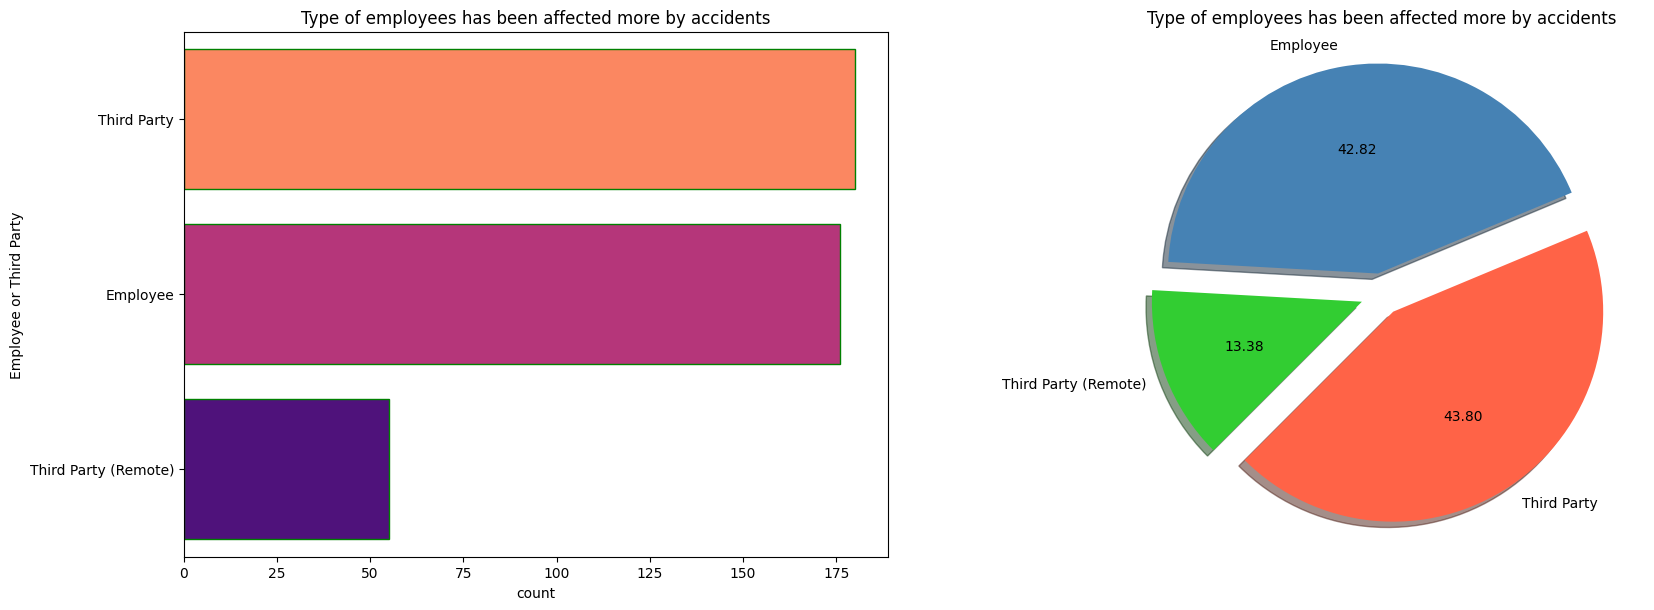

In [78]:
plot(industry_df,'Employee or Third Party', 'Type of employees has been affected more by accidents', 'magma_r', 'green')

**Observations**
1. **Third Party (180 cases, 44%)** – Highest accident count, indicating possible lack of safety training or supervision.  
2. **Employee (176 cases, 43%)** – Nearly equal to third-party accidents, requiring internal safety improvements.  
3. **Third Party (Remote) (55 cases, 13%)** – Lower but still notable, suggesting risks even for off-site workers.

## Accident Level

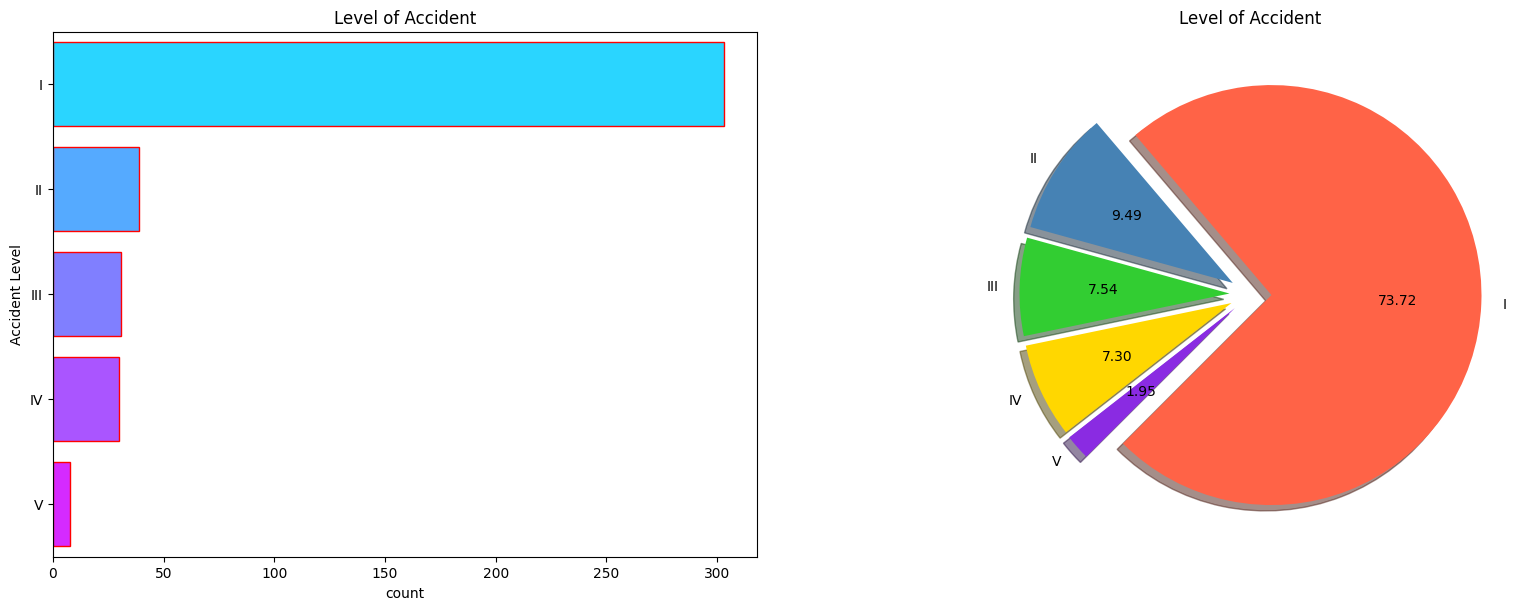

In [79]:
plot(industry_df,'Accident Level', 'Level of Accident', 'cool', 'red')

**Observations**
1. **Level I (303 cases, 83%)** – Most accidents are minor but still require preventive measures.  
2. **Level II (39 cases, 11%)** – Moderate severity, needing improved safety interventions.  
3. **Level III (31 cases, 8%) & Level IV (30 cases, 8%)** – Serious incidents, requiring stricter safety enforcement.  
4. **Level V (8 cases, 2%)** – Critical cases, demanding urgent safety overhauls.

## Potential Accident Level

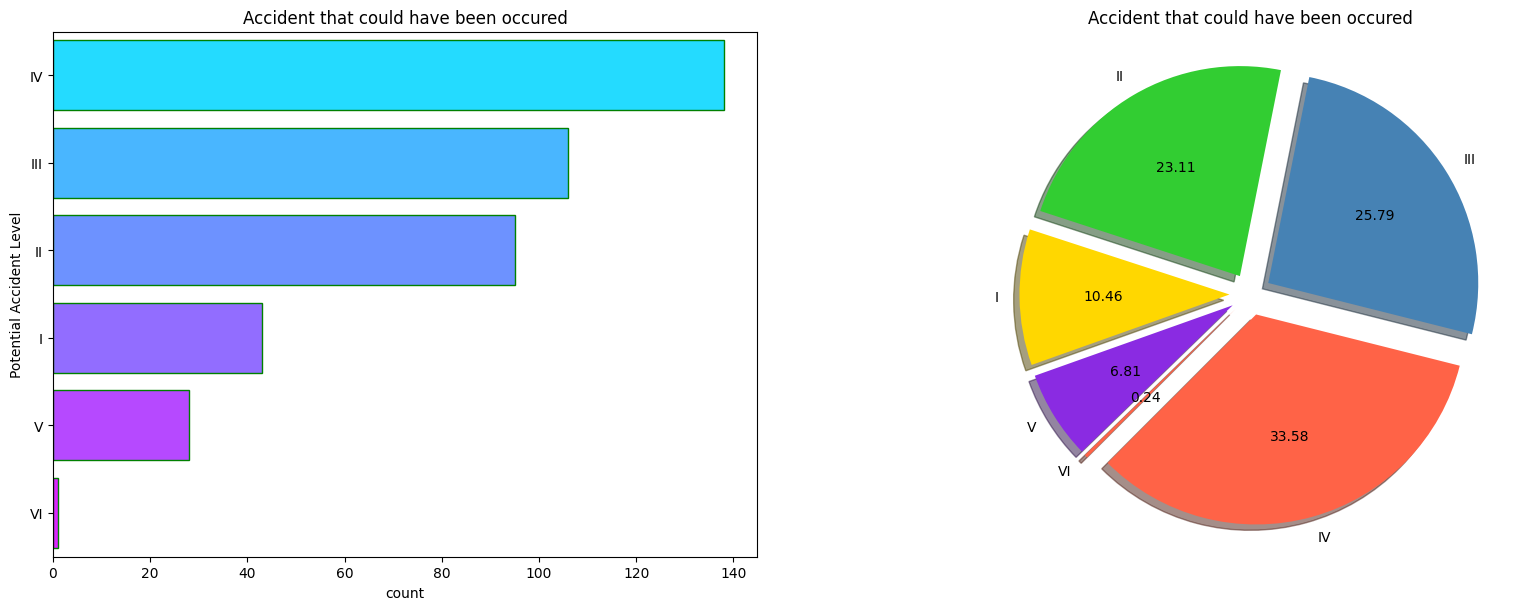

In [80]:
plot(industry_df,'Potential Accident Level', 'Accident that could have been occured', 'cool', 'green')

**Observations**
1. **Level IV (138 cases, 33%)** – Highest potential severity, requiring strong preventive measures.  
2. **Level III (106 cases, 25%)** – Significant risk, indicating a need for better hazard control.  
3. **Level II (95 cases, 23%)** – Moderate risk, requiring safety reinforcements.  
4. **Level I (43 cases, 10%)** – Lower potential severity but still needs monitoring.  
5. **Level V (28 cases, 7%) & Level VI (1 case, <1%)** – Critical risk, demanding immediate safety interventions.  

## Local (Localities where accident occured)

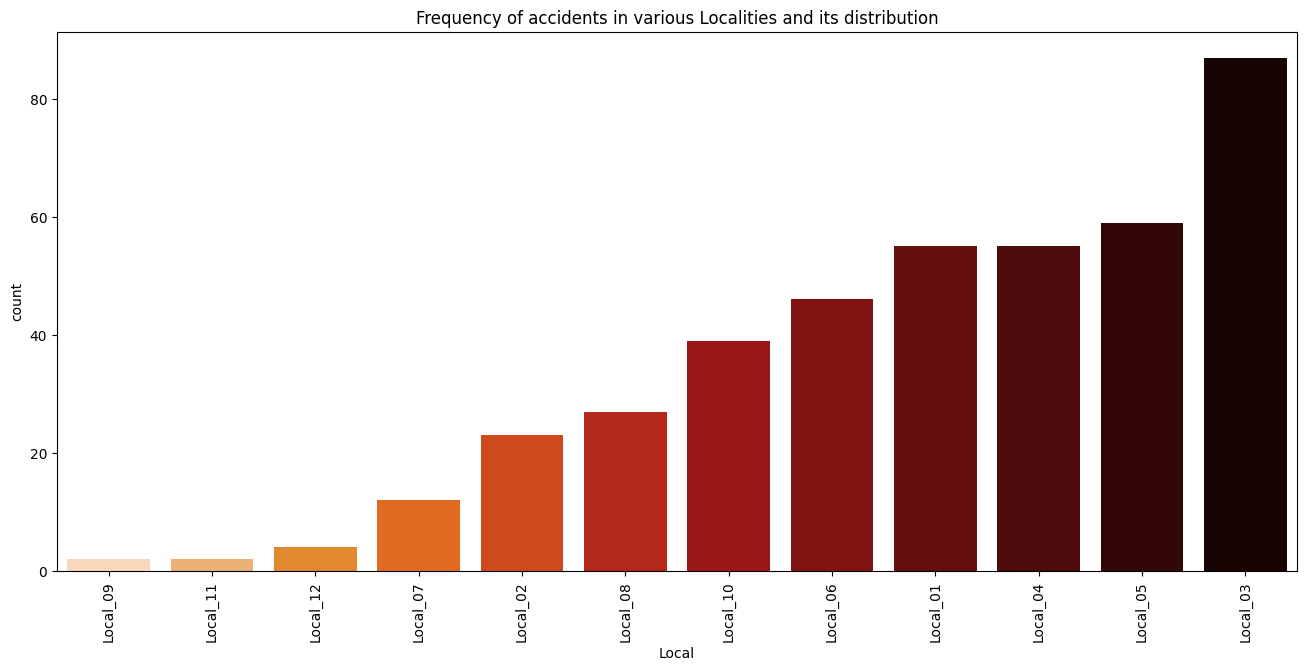

In [81]:
# Local Count
plt.figure(figsize = (16,7))
ax = sns.countplot(x = industry_df['Local'], order=industry_df['Local'].value_counts().sort_values(ascending = True).index, palette = 'gist_heat_r');
plt.title('Frequency of accidents in various Localities and its distribution');
plt.xticks(rotation = 'vertical')
plt.show()

**Observations**

1. **Local_03 (87 cases)** has the highest number of accidents, indicating a possible hotspot for safety issues.  
2. **Local_05 (59 cases)** and **Local_01 (55 cases)** also show significant accident counts, highlighting other key areas of concern.  
3. **Local_06 (46 cases)** and **Local_10 (39 cases)** have moderate accident occurrences, requiring targeted safety interventions.  
4. **Local_09 (2 cases)** and **Local_11 (2 cases)** report the fewest accidents, possibly reflecting fewer risks or better safety measures.

## Critical Risk

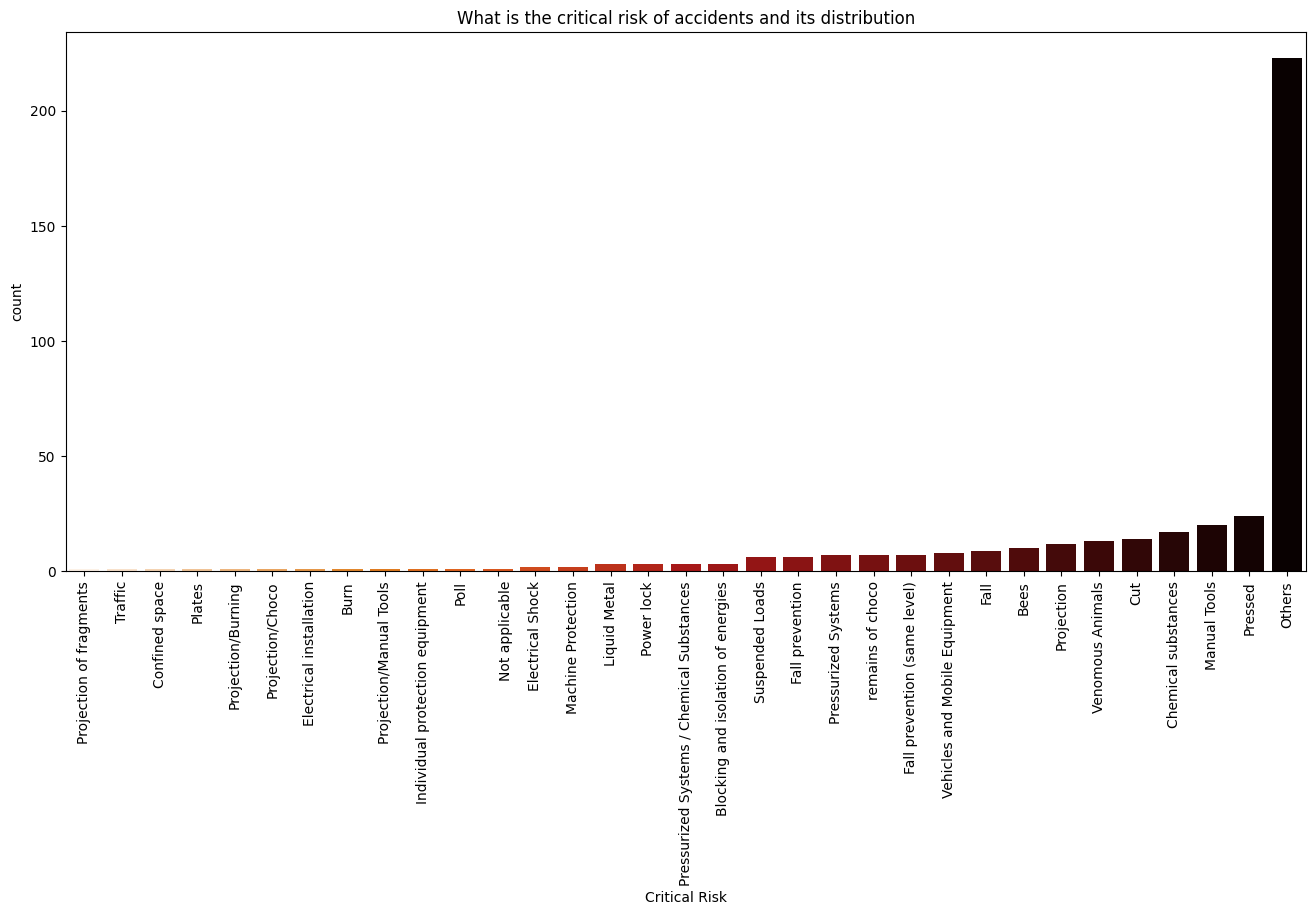

In [82]:
# Critical Risk Count
plt.figure(figsize = (16,7))
ax = sns.countplot(x = industry_df['Critical Risk'], order=industry_df['Critical Risk'].value_counts().sort_values(ascending = True).index, palette = 'gist_heat_r');
plt.title('What is the critical risk of accidents and its distribution');
plt.xticks(rotation = 'vertical')
plt.show()

**observations**
1. **"Others"** represents the majority of critical risks (223 cases), suggesting a broad range of unspecified hazards.  
2. **Pressed machinery (24 cases)** and **manual tools (20 cases)** are significant risks, indicating the need for better handling and safety measures.  
3. **Chemical substances (17 cases)** and **venomous animals (13 cases)** highlight specific hazards requiring focused protocols.  
4. Several risks like **fall prevention** and **suspended loads** emphasize areas that need targeted safety interventions.

# Bi-Variate analysis

In [83]:
# Creating a function to make bivariate plots for analysis

def plot_count_with_hue(df, column, hue, figsize, palette, title='Count Plot'):
    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df,
        x=column,
        hue=df[hue],
        hue_order=df[hue].value_counts().sort_index().index,
        palette=palette,
        edgecolor='.4',
        saturation=1
    )
    for p in ax.patches:
        ax.annotate(
            '{:.0f}'.format(p.get_height()),
            (p.get_x(), p.get_height()),
            size=12,
            xytext=(0, 3),
            textcoords='offset points'
        )

    plt.title(title)
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    plt.show()



## Accident level counts by Country

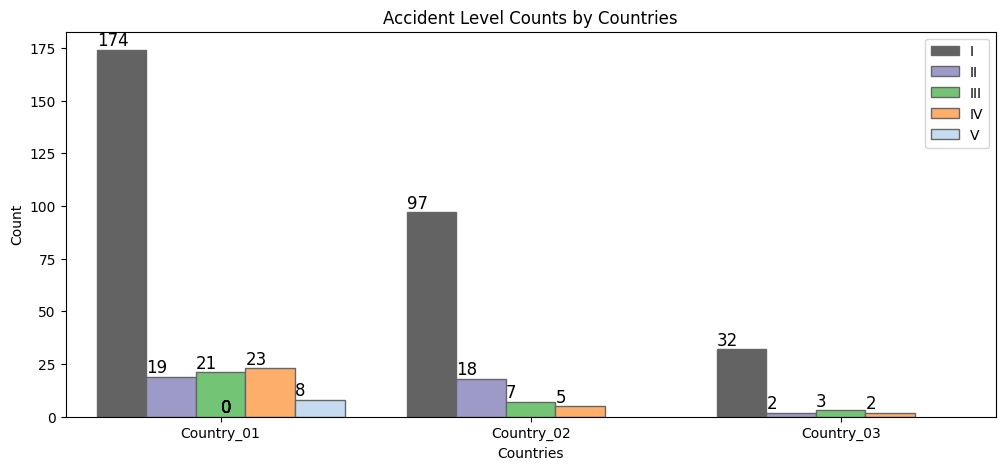

In [84]:
plot_count_with_hue(industry_df, 'Countries', 'Accident Level', figsize=(12, 5),palette='tab20c_r', title='Accident Level Counts by Countries')

**Observations**

   - **Country_01** has the highest number of accidents across all levels, with **174 Level I accidents**.  
   - **Country_02** has **97 Level I accidents**, with fewer Level IV and no recorded Level V accidents.  
   - **Country_03** has the fewest accidents overall (**32 at Level I**).


## Accident level counts by Local

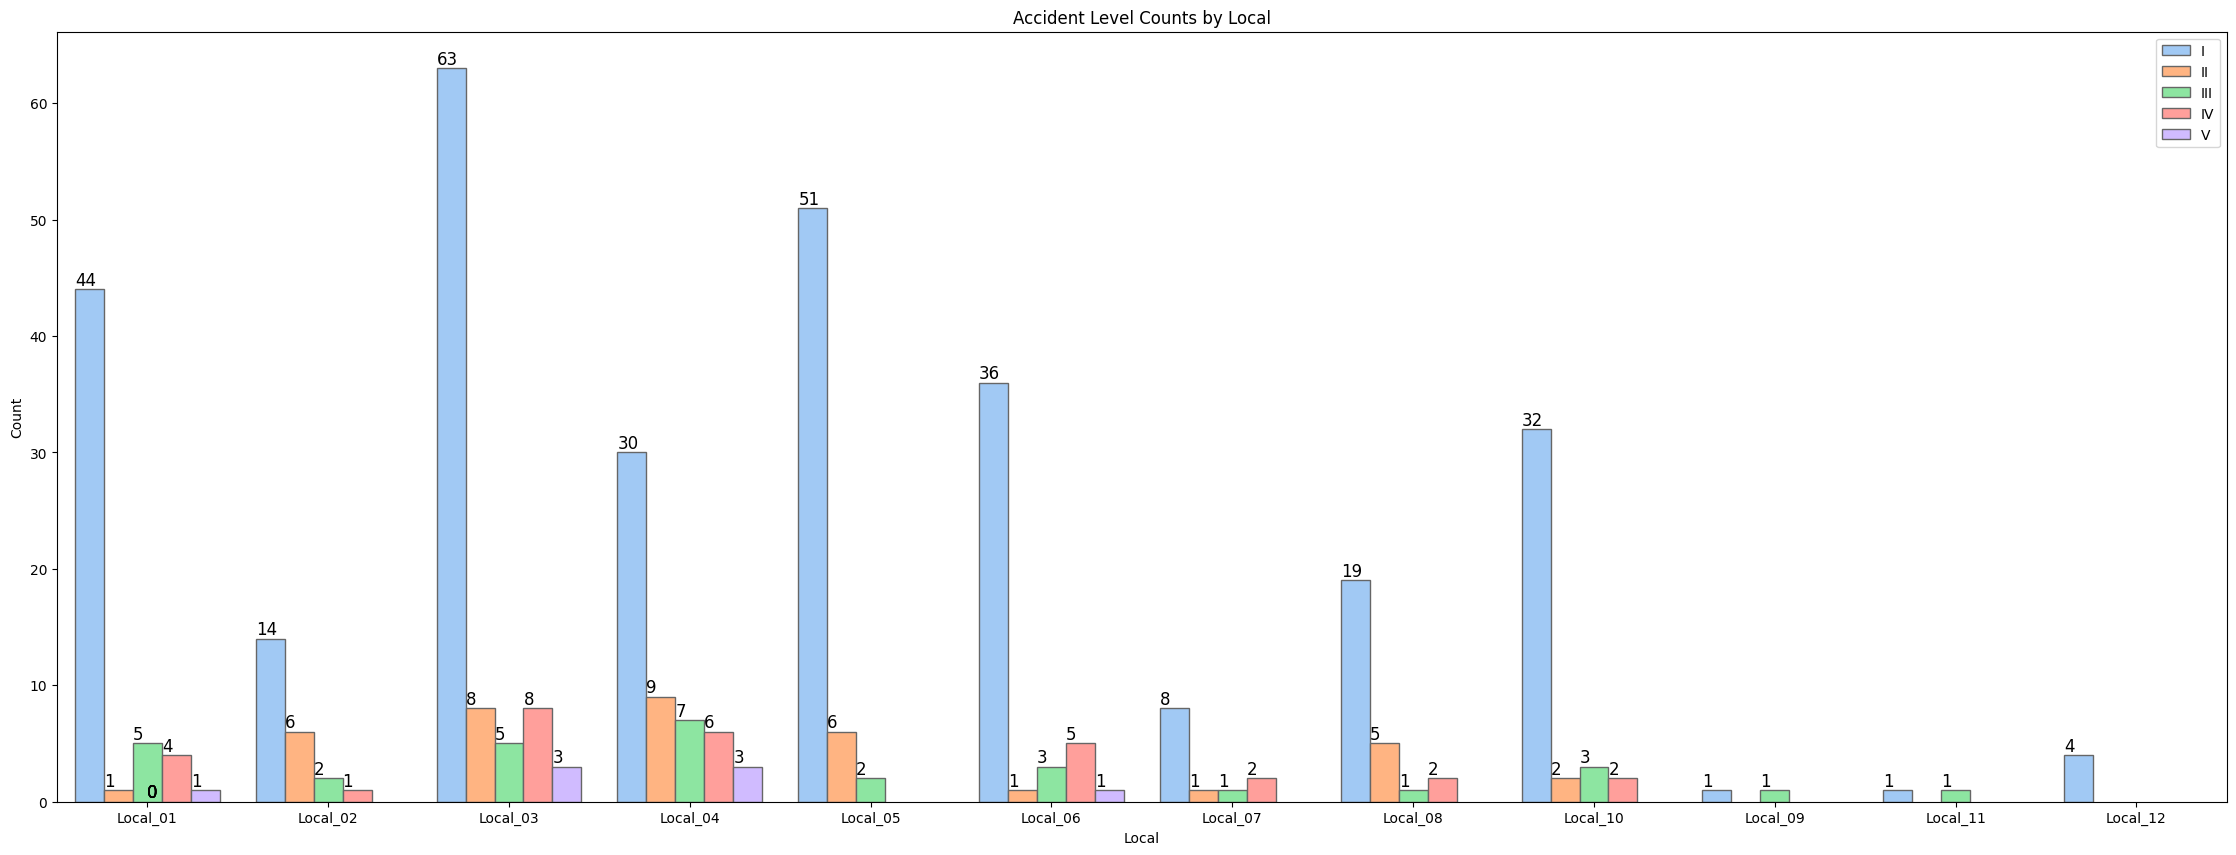

In [85]:
plot_count_with_hue(industry_df, 'Local', 'Accident Level', figsize=(28, 10),palette='pastel', title='Accident Level Counts by Local')

**Observations**

1. **Highest Level I Accidents:**  
   - **Local_03 (63)** has the highest number of Level I accidents, followed by **Local_05 (51)** and **Local_01 (44)**.  

2. **Highest Level II Accidents:**  
   - **Local_04 (9)** has the most Level II accidents, followed by **Local_03 (8)** and **Local_02 (6)**.  

3. **Highest Level III Accidents:**  
   - **Local_04 (7)** has the most Level III accidents, followed by **Local_01 and Local_03 (5 each)**.  

4. **Highest Level IV Accidents:**  
   - **Local_03 (8)** has the most Level IV accidents, followed by **Local_04 (6)**.  
   - **Local_05, Local_09, Local_11, and Local_12 have no recorded Level IV accidents**.  

5. **Highest Level V Accidents:**  
   - **Local_03 and Local_04 (3 each)** have the most Level V accidents.  
   - **Several locations (Local_02, Local_05, Local_07, Local_08, Local_09, Local_10, Local_11, Local_12) have no recorded Level V accidents**.  

6. **Locations with the Lowest Total Accidents:**  
   - **Local_09 and Local_11 (each with only 2 recorded accidents across all levels)**.  
   - **Local_12 has only 4 accidents, all in Level I**.


## Accident level counts by Industry Sector

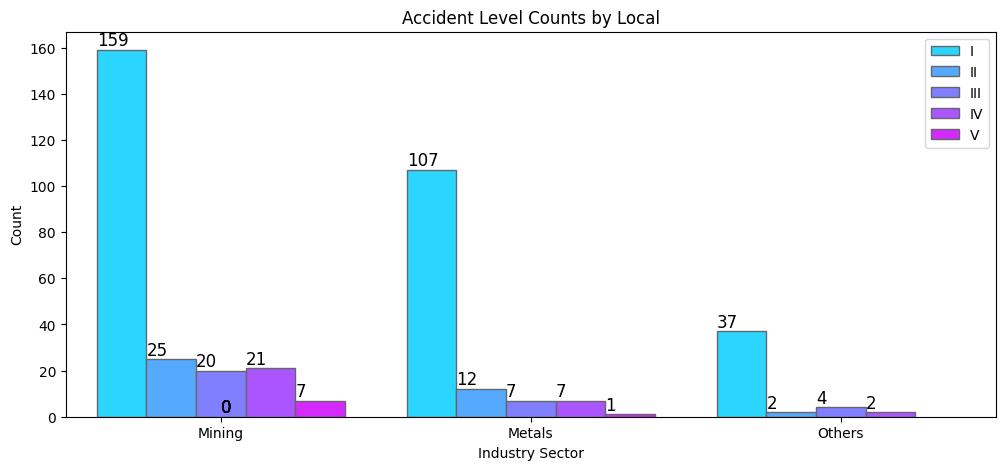

In [86]:
plot_count_with_hue(industry_df, 'Industry Sector', 'Accident Level', figsize=(12, 5),palette='cool', title='Accident Level Counts by Local')

**Observations**

- **Level I:** Mining (159) has the highest, Others (37) the lowest.  
- **Level II:** Mining (25) leads, Others (2) has the least.  
- **Level III:** Mining (20) is highest, Others (4) is lowest.  
- **Level IV:** Mining (21) has the most, Others (2) the least.  
- **Level V:** Mining (7) is the highest, Others has no recorded cases.


## Accident level counts by Employee or Third Party

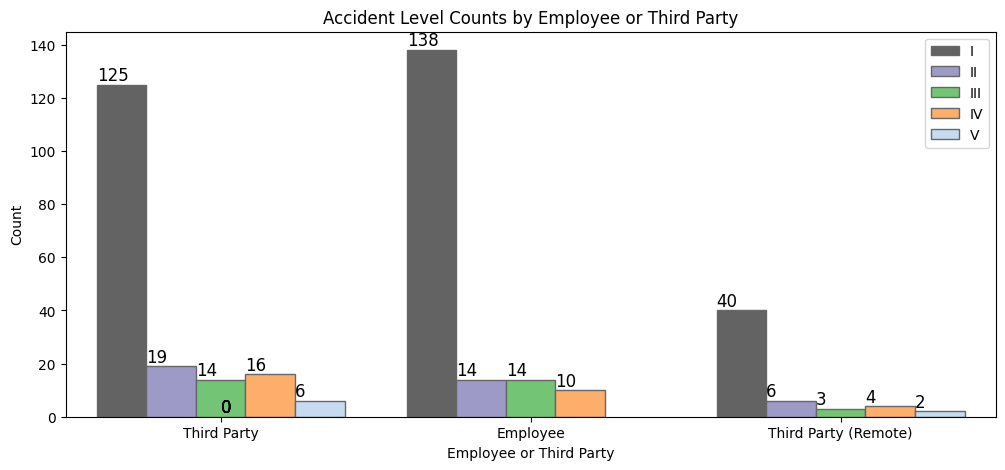

In [87]:
plot_count_with_hue(industry_df, 'Employee or Third Party', 'Accident Level', figsize=(12, 5),palette='tab20c_r', title='Accident Level Counts by Employee or Third Party')

**Observations**

- **Accident Level I:** Employee (138) has the highest, Third Party (Remote) (40) the lowest.  
- **Accident Level II:** Third Party (19) leads, Third Party (Remote) (6) is the lowest.  
- **Accident Level III:** Employee and Third Party (14 each) are highest, Third Party (Remote) (3) is the lowest.  
- **Accident Level IV:** Third Party (16) has the most, Third Party (Remote) (4) the least.  
- **Accident Level V:** Third Party (6) is the highest, Employee has no recorded cases.


## Accident level counts by Critical Risk

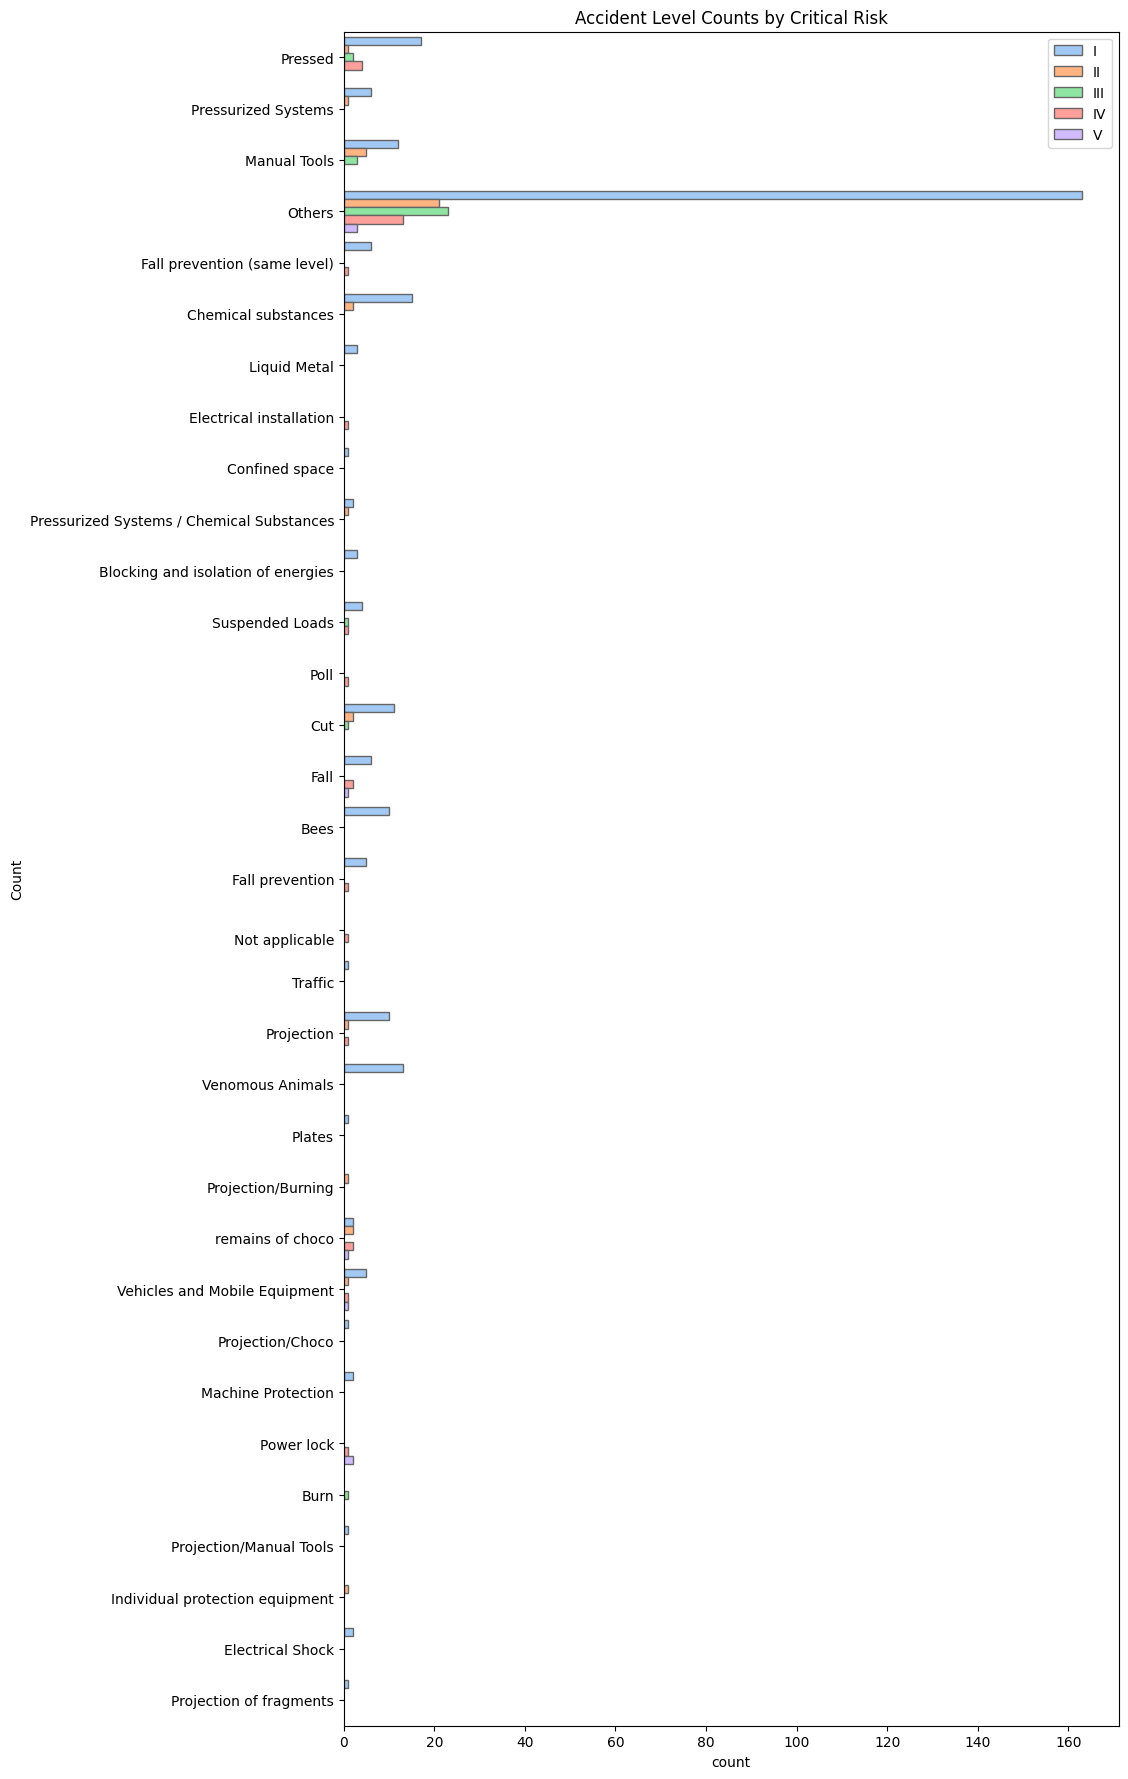

In [88]:
plt.figure(figsize=(10,22))
ax = sns.countplot(y = industry_df['Critical Risk'], hue=industry_df['Accident Level'], hue_order=industry_df['Accident Level'].value_counts().sort_index().index, palette='pastel', edgecolor='.4', saturation=1)
plt.title('Accident Level Counts by Critical Risk');
plt.ylabel('Count');
plt.legend(loc='upper right')

**Observations**

- **Accident Level I:** Mining (159) has the highest, Others (37) the lowest.  
- **Accident Level II:** Mining (25) leads, Others (2) has the least.  
- **Accident Level III:** Mining (20) is highest, Others (4) is lowest.  
- **Accident Level IV:** Mining (21) has the most, Others (2) the least.  
- **Accident Level V:** Mining (7) is the highest, Others has no recorded cases.


## Accident level counts by `Countries` and Industry Sector

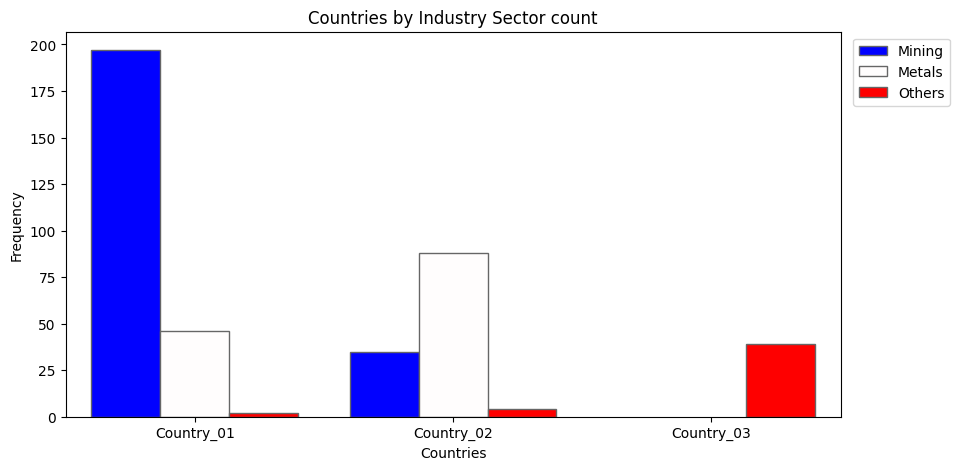

In [89]:
plt.figure(figsize=(10,5))
sns.countplot(x='Countries', hue='Industry Sector', data=industry_df, edgecolor='.4', saturation=1, palette='seismic')
plt.title('Countries by Industry Sector count')
plt.ylabel('Frequency')
plt.legend(loc='best', bbox_to_anchor=(1.15, 1))
plt.show()


**Observations**

1. **Mining is the most hazardous sector**, with **Country_01 (197 accidents)** having the highest count.  
2. **Metals industry accidents are higher in Country_02 (88 incidents)** compared to Country_01 (46).  
3. **Country_03 reports accidents only in the 'Others' sector (39 incidents)**, indicating unique risks.  
4. **Mining (232 total accidents) poses the greatest safety concerns across countries.**  

## Industry Sector by Gender Count

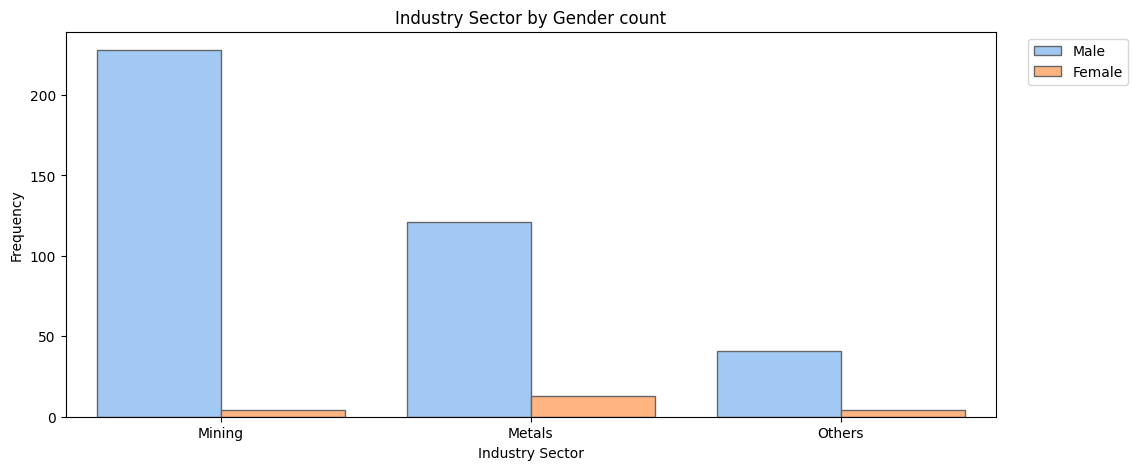

In [90]:
plt.figure(figsize=(12,5))
sns.countplot(x='Industry Sector', hue='Gender', data=industry_df, edgecolor='.4', saturation=1, palette='pastel')
plt.title('Industry Sector by Gender count')
plt.ylabel('Frequency')
plt.legend(loc='best', bbox_to_anchor=(1.15, 1))
plt.show()

**Observations**

1. **Males experience significantly more accidents** across all sectors (**390 total incidents vs. 21 for females**).  
2. **Mining is the most hazardous industry**, with **228 accidents among males** and only **4 among females**.  
3. **Metals sector has 121 male and 13 female accidents**, showing a similar gender disparity.  
4. **The 'Others' sector reports 41 male and 4 female accidents**, maintaining the trend of higher male incidents.  


# Correlation

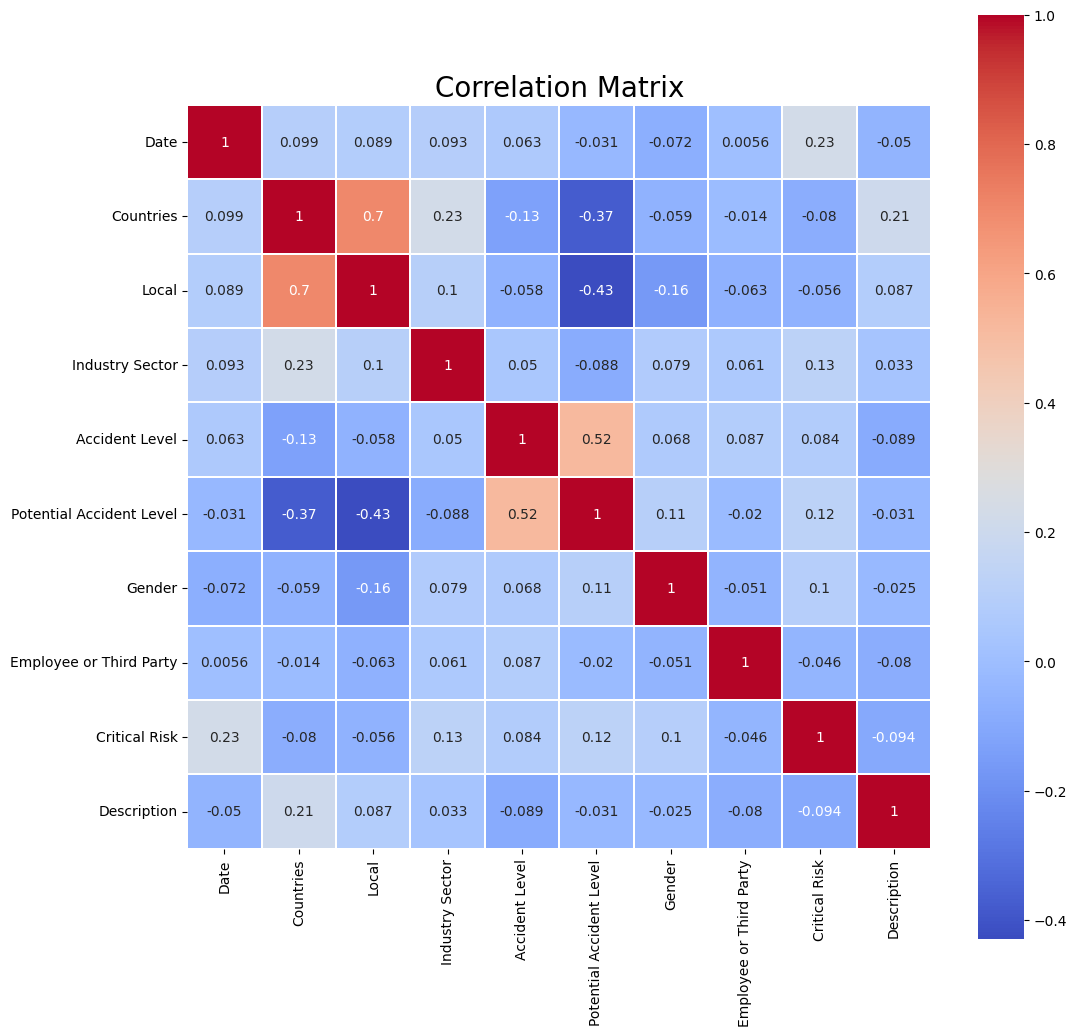

In [91]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le = LabelEncoder()
df_enc = industry_df.apply(le.fit_transform)

# Compute correlation matrix
correlation_matrix = df_enc.corr()
# Plot heatmap with a different colormap
plt.figure(figsize=(12,12))
plt.title('Correlation Matrix', fontsize=20)
sns.heatmap(correlation_matrix, square=True, cmap='coolwarm', annot=True, linewidth=0.2)  # Changed cmap to 'coolwarm'
plt.show()

**Observations**

1. **Date & Critical Risk (+0.23)** → Accidents with higher risks tend to occur on specific dates.  
2. **Date & Countries (+0.10)** → Slightly positive correlation; certain accident patterns may vary by country over time.  
3. **Countries & Local (+0.70)** → Strong correlation, as local plant locations are country-dependent.  
4. **Countries & Potential Accident Level (-0.37)** → Some countries have lower recorded potential accident severity.  
5. **Industry Sector & Critical Risk (+0.13)** → Certain industry sectors face more critical risks than others.  
6. **Accident Level & Potential Accident Level (+0.52)** → More severe accidents generally had higher potential severity.  
7. **Accident Level & Gender (+0.07)** → Weak correlation, indicating gender is not a strong factor in accident severity.  
8. **Employee or Third Party & Accident Level (+0.09)** → Employees tend to be involved in slightly more severe accidents.  
9. **Critical Risk & Potential Accident Level (+0.12)** → High-risk accidents tend to have a greater potential severity.  
10. **Description & Countries (+0.21)** → Accident descriptions vary by country, possibly due to reporting styles.  


# NLP Pre-Processing